In [2]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/")
from sklearn.cluster import DBSCAN, HDBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [15]:
dic = torch.load("/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/090824/graphs/2.pt", map_location='cpu')


In [39]:
from src.layers.inference_oc_tracks import hfdb_obtain_labels, get_clustering
from sklearn.cluster import DBSCAN, HDBSCAN
g= dgl.unbatch(dic["graph"])[3]
betas = torch.sigmoid(g.ndata["model_output"][:,3])
X = g.ndata["model_output"][:,0:3]
clustering1 = get_clustering(betas, X, tbeta=0.6, td=0.2)
hdb = DBSCAN(min_samples=8, eps=0.1).fit(
        X.detach().cpu()
    )
torch.unique(g.ndata["particle_number"])

tensor([1., 2.])

In [40]:
hdb.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3, -1, -1, -1,  3,  3])

In [20]:
hdb

DBSCAN(eps=0.1, min_samples=8)

In [30]:
labels.shape, dic["graph"].ndata["model_output"][:,0:3].shape

(torch.Size([194]), torch.Size([194, 3]))

In [7]:
# graph = dic["graph"]
# labels_ = graph.ndata["ct_track_label"].long() + 1
# map_from = list(np.unique(labels_.detach().cpu()))
# labels = map(lambda x: map_from.index(x), labels_)
# labels = (
#     torch.Tensor(list(labels))
#     .long()
#     .to(dic["graph"].ndata["coords"].device)
# )
from src.layers.inference_oc_tracks import hfdb_obtain_labels
betas = torch.sigmoid(dic["graph"].ndata["model_output"])
X = dic["graph"].ndata["coords"]
labels = hfdb_obtain_labels(X, betas.device)


particle_ids = torch.unique(dic["graph"].ndata["particle_number"])
shower_p_unique = torch.unique(labels)
print("particle_ids",particle_ids)
print("shower_p_unique",shower_p_unique)

KeyError: 'beta'

In [7]:
from src.layers.inference_oc_tracks import obtain_intersection_matrix, obtain_union_matrix, generate_showers_data_frame, match_showers
shower_p_unique, row_ind, col_ind, i_m_w, iou_matrix = match_showers(
            labels,
            dic,
            particle_ids,
            graph.ndata["ct_track_label"].long(),
            0,
            0,
            None,
        )
df_event1, number_of_showers_total = generate_showers_data_frame(
                labels,
                dic,
                shower_p_unique,
                particle_ids,
                row_ind,
                col_ind,
                i_m_w,
                number_of_showers_total=0,
                step=0,
                number_in_batch=0,
            )

In [8]:
df_event1

,reco_showers_E,true_showers_E,true_showers_pt,pred_showers_E,e_pred_and_truth,vtx_hits,cdc_hits,delta_MC,R,theta,gen_status,number_unique_hits
0,14.0,1.408047,1.065244,10.0,10.0,6.0,0.0,0.646434,0.000992,2.283586,1.0,13.0
1,14.0,0.393755,0.227257,14.0,14.0,4.0,0.0,1.295341,0.000992,2.526353,1.0,12.0
2,20.0,0.608339,0.208656,14.0,14.0,6.0,0.0,0.454199,0.000992,0.350102,1.0,18.0
3,14.0,0.104104,0.102891,3.0,3.0,7.0,0.0,1.137775,0.000992,1.723591,1.0,9.0
4,19.0,13.464619,3.066793,13.0,13.0,4.0,0.0,0.320912,0.000992,0.229784,1.0,17.0
5,4.0,4.175058,0.487972,3.0,3.0,2.0,0.0,0.442975,0.000992,0.117146,1.0,4.0
6,16.0,1.813406,0.601026,12.0,12.0,4.0,0.0,0.404287,0.000992,0.337824,1.0,15.0
7,10.0,0.388859,0.130945,5.0,5.0,0.0,0.0,1.175653,0.111549,2.798140,0.0,8.0
8,7.0,1.244539,0.515698,NaN,NaN,0.0,0.0,0.454199,0.302689,0.427249,0.0,4.0
9,6.0,0.015672,0.009635,NaN,NaN,0.0,0.0,0.646434,0.127525,2.479493,0.0,4.0


In [9]:
unique_labels = torch.unique(labels)
for i in range(0,len(torch.unique(labels))):    
    mask = labels == unique_labels[i]
    print(len(torch.unique(graph.ndata["unique_id"][mask])), len(graph.ndata["unique_id"][mask]))

23 54
9 10
12 13
11 12
4 4
12 14
5 5
12 14
4 4
3 3
3 3
5 5
4 4
5 5


In [112]:
unique_hits_per_track = calculate_number_of_unique_hits_per_track(labels, dic)

e_pred_showers = 1.0 * scatter_add(
    torch.ones_like(labels).view(-1),
    labels.long(),
)
e_reco_showers = scatter_add(
        torch.ones_like(labels).view(-1),
        dic["graph"].ndata["particle_number"].long(),
    )
e_reco_showers = e_reco_showers[1:]
row_ind = torch.Tensor(row_ind).to(e_pred_showers.device).long()
col_ind = torch.Tensor(col_ind).to(e_pred_showers.device).long()
if torch.sum(particle_ids == 0) > 0:
    # particle id can be 0 because there is noise
    # then row ind 0 in any case corresponds to particle 1.
    # if there is particle_id 0 then row_ind should be +1?
    row_ind_ = row_ind - 1
else:
    # if there is no zero then index 0 corresponds to particle 1.
    row_ind_ = row_ind

In [113]:
row_ind_

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15])

In [114]:
matched_es = torch.zeros_like(e_reco_showers) * (torch.nan)
matched_es = matched_es.to(e_pred_showers.device)
index_matches = col_ind + 1
index_matches = index_matches.to(e_pred_showers.device).long()

In [115]:
col_ind

tensor([ 4,  6,  1,  2,  7,  8, 11,  5,  9, 10, 14,  3,  0, 12, 13])

In [116]:
matched_es[row_ind_] = e_pred_showers[index_matches]
matched_es

tensor([11.,  4., 11., 11., 12., 10.,  3., 10.,  6.,  5.,  6., 13., 13., nan,
         5.,  5., nan, nan, nan, nan, nan, nan, nan, nan])

In [117]:
e_pred_showers[index_matches]

tensor([11.,  4., 11., 11., 12., 10.,  3., 10.,  6.,  5.,  6., 13., 13.,  5.,
         5.])

In [118]:
row_ind_

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15])

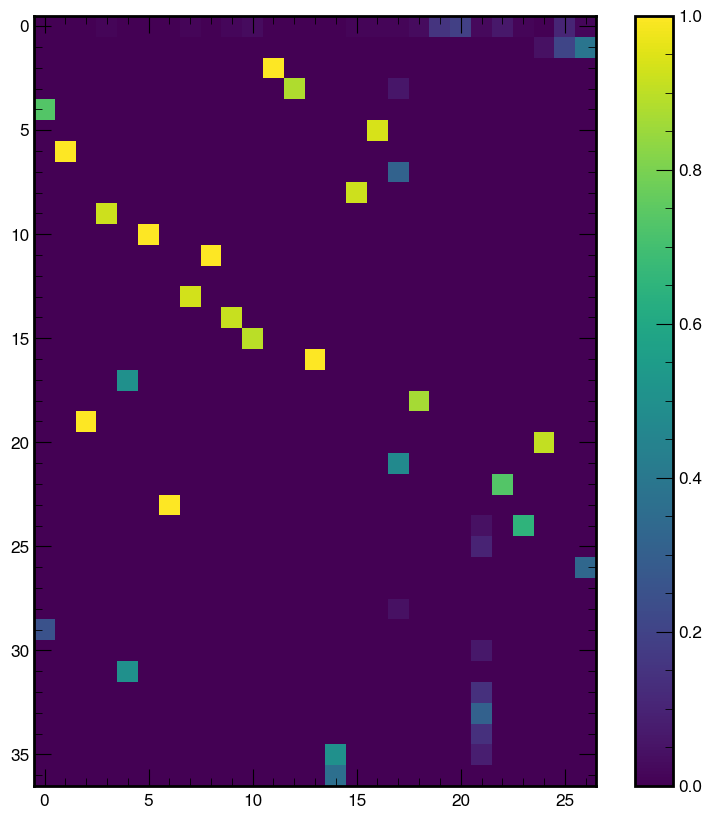

In [75]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow( torch.transpose(iou_matrix[1:, :], 1, 0).clone().detach().cpu().numpy())
plt.colorbar()
plt.show()

In [13]:
df = df_event_pandora
mask_nan_showers = np.isnan(df["reco_showers_E"].values)*(df["pred_showers_E"].values<4)
df = df.drop(mask_nan_showers.nonzero()[0])
mask = ~np.isnan(df["reco_showers_E"])
showers_are_not_nan = ~np.isnan(df["pred_showers_E"][mask].values)
showers_have_higher_than_75 = (df["e_pred_and_truth"][mask].values)>=4
eff = np.sum(showers_are_not_nan*showers_have_higher_than_75) / len(
    df["pred_showers_E"][mask].values
)
print(eff)
df

0.6071428571428571


,reco_showers_E,true_showers_E,pred_showers_E,e_pred_and_truth,vtx_hits,cdc_hits,delta_MC,R,theta
0,12.0,0.795633,7.0,7.0,6.0,0.0,0.113485,0.000794,1.099758
1,8.0,0.106051,4.0,4.0,6.0,0.0,0.985839,0.000794,2.370435
2,12.0,2.093235,10.0,10.0,6.0,0.0,0.477026,0.000794,1.179044
3,16.0,0.758106,12.0,12.0,6.0,0.0,0.867732,0.000794,0.530845
4,11.0,6.386620,5.0,5.0,6.0,0.0,0.093558,0.000794,1.137952
5,9.0,0.723819,7.0,7.0,6.0,0.0,0.565367,0.000794,1.875376
6,15.0,0.477534,5.0,5.0,9.0,0.0,0.287478,0.000794,1.946246
7,18.0,0.345217,5.0,5.0,6.0,0.0,0.113485,0.000794,1.193946
8,10.0,0.265652,5.0,5.0,7.0,0.0,0.152602,0.000794,1.859471
9,7.0,0.335788,6.0,5.0,6.0,0.0,0.335236,0.000794,1.129345


In [8]:
from src.layers.inference_oc_tracks import get_clustering
dic["graph"].ndata["coords"] = dic["graph"].ndata["model_output"][:,0:3]
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "clustering_normal"
clustering1 = get_clustering(betas,X,tbeta=0.5, td=0.2)
map_from = list(np.unique(clustering1))
cluster_id = map(lambda x: map_from.index(x), clustering1)
clustering_ordered = torch.Tensor(list(cluster_id)).long()
if torch.unique(clustering1)[0] != -1:
    clustering = clustering_ordered + 1
else:
    clustering = clustering_ordered
clustering = np.reshape(clustering, (-1))
clustering = torch.Tensor(clustering).long()
# elif clustering_mode == "dbscan":
# db = HDBSCAN(min_cluster_size=8, min_samples=8, cluster_selection_epsilon=0.05).fit(X)
# labels_hdb = db.labels_ +1
# labels_hdb = np.reshape(labels_hdb, (-1))
# labels_hdb = torch.Tensor(labels_hdb).long()
# labels = hfdb_obtain_labels(X, betas.device)

from src.layers.inference_oc_tracks import match_showers, generate_showers_data_frame
labels = clustering
model_output = torch.cat((dic["graph"].ndata["coords"], dic["graph"].ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(dic["graph"].ndata["particle_number"])
shower_p_unique = torch.unique(labels)
shower_p_unique, row_ind, col_ind, i_m_w, iou_matrix= match_showers(
    labels,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
)
df_event, number_of_showers_total = generate_showers_data_frame(
                labels,
                dic,
                shower_p_unique,
                particle_ids,
                row_ind,
                col_ind,
                i_m_w,
                number_of_showers_total=0,
                step=0,
                number_in_batch=0,
            )

# df_event["pred_showers_E"][df_event["pred_showers_E"]<3]=np.nan
# df_event1 = df_event.drop(1*(np.isnan(df_event["reco_showers_E"].values)).nonzero()[0])
# df_event1

In [10]:
df = df_event 
mask_nan_showers = np.isnan(df["reco_showers_E"].values)*(df["pred_showers_E"].values<4)
df = df.drop(mask_nan_showers.nonzero()[0])
mask = ~np.isnan(df["reco_showers_E"])
showers_are_not_nan = ~np.isnan(df["pred_showers_E"][mask].values)
showers_have_higher_than_75 = (df["e_pred_and_truth"][mask].values)>=4
eff = np.sum(showers_are_not_nan*showers_have_higher_than_75) / len(
    df["pred_showers_E"][mask].values
)
print(eff)
df

0.7857142857142857


,reco_showers_E,true_showers_E,pred_showers_E,e_pred_and_truth,vtx_hits,cdc_hits,delta_MC,R,theta
0,12.0,0.795633,14.0,12.0,6.0,0.0,0.113485,0.000794,1.099758
1,8.0,0.106051,8.0,8.0,6.0,0.0,0.985839,0.000794,2.370435
2,12.0,2.093235,12.0,12.0,6.0,0.0,0.477026,0.000794,1.179044
3,16.0,0.758106,18.0,16.0,6.0,0.0,0.867732,0.000794,0.530845
4,11.0,6.386620,12.0,11.0,6.0,0.0,0.093558,0.000794,1.137952
5,9.0,0.723819,10.0,9.0,6.0,0.0,0.565367,0.000794,1.875376
6,15.0,0.477534,13.0,12.0,9.0,0.0,0.287478,0.000794,1.946246
7,18.0,0.345217,12.0,12.0,6.0,0.0,0.113485,0.000794,1.193946
8,10.0,0.265652,10.0,9.0,7.0,0.0,0.152602,0.000794,1.859471
9,7.0,0.335788,10.0,7.0,6.0,0.0,0.335236,0.000794,1.129345


In [8]:
# import plotly
# import plotly.graph_objs as go
# line = dict(color="black", width=1)
# def plot_single_arrow(
#     fig, vec,  init_pt=[0, 0, 0], line=line
# ):
#     # init_pt: initial point of the vector
#     fig.add_trace(
#         go.Scatter3d(
#             x=[init_pt[0], vec[0] + init_pt[0]],
#             y=[init_pt[1], init_pt[1] + vec[1]],
#             z=[init_pt[2], init_pt[2] + vec[2]],
#             mode="lines",
#             line=line,
#         )
#     )
#     fig.add_trace(
#         go.Scatter3d(
#             x=[vec[0] + init_pt[0]],
#             y=[vec[1] + init_pt[1]],
#             z=[vec[2] + init_pt[2]],
#             mode="markers",
#             marker=dict(size=4, color="black"),
#             # hovertext=hovertext,
#         )
#     )

In [28]:
g.ndata["particle_number"]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])

In [44]:

import pandas as pd
import plotly.express as px

from src.logger.plotting_tools import shuffle_truth_colors
g = dgl.unbatch(dic["graph"])[3]
mask = (g.ndata['particle_number'] !=-1)  #+(g.ndata['ct_track_label'] ==7) #+(g.ndata['particle_number'] ==20) 
tidx =  torch.Tensor(hdb.labels_)[mask].view(-1,1)# 1*(g.ndata['particle_number'][mask]).view(-1,1)  #labels[mask].view(-1,1)
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features = 1*(torch.ones_like(torch.sigmoid(g.ndata["model_output"][mask][:,3])).view(-1,1))
cellid= g.ndata['particle_number'][mask].view(-1,1)
X = g.ndata["pos_hits_xyz"][mask][:,0:3] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
            # "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}


df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx", "cellid"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
# fig = go.Figure()
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
# hover_data=hover_data,
template="simple_white",
range_color=[-1,4],
# color_continuous_scale=px.colors.sequential.Turbo,
)
# fig.update_layout(
#     scene = dict(
#         xaxis = dict(visible=False),
#         yaxis = dict(visible=False),
#         zaxis =dict(visible=False)
#         )
#     )
fig.update_traces(marker=dict(line=dict(width=0)))
# fig.update_traces(marker_size = 2)
# mask_cdc= (g.ndata['hit_type'][mask] ==0)
# X_cdc = g.ndata["pos_hits_xyz"][mask][mask_cdc]
# vector_cdc = g.ndata["vector"][mask][mask_cdc]
# for i in range(0,torch.sum(g.ndata['hit_type'][mask] ==0)):
#     plot_single_arrow(fig,vector_cdc[i]*25,init_pt= X_cdc[i])
# fig.update_traces(marker=dict(line=dict(width=0)))
# fig.update_traces(marker_size = 2)
# fig.update_layout(
#     autosize=False,
#     width=800,
#     height=800,
# )
fig.show()

In [25]:
g

Graph(num_nodes=42, num_edges=0,
      ndata_schemes={'vector': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32), 'pos_hits_xyz': Scheme(shape=(3,), dtype=torch.float32), 'cellid': Scheme(shape=(1,), dtype=torch.float32), 'model_output': Scheme(shape=(4,), dtype=torch.float32)}
      edata_schemes={})

In [159]:
len(torch.unique(graph.ndata["unique_id"][graph.ndata["particle_number"]==1]))

13

In [157]:
torch.unique(graph.ndata["unique_id"][graph.ndata["ct_track_label"]==0])*1.0

tensor([2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00, 1.3107e+05, 1.3107e+05,
        1.3107e+05, 1.9661e+05, 3.9296e+05])

In [77]:

# import pandas as pd
# import plotly.express as px

# from src.logger.plotting_tools import shuffle_truth_colors
# g = dgl.unbatch(dic["graph"])[0]
# mask = (g.ndata['particle_number'] ==6) #+(g.ndata['particle_number'] ==13)+(g.ndata['particle_number'] ==20) 
# tidx =  labels[mask].view(-1,1)
# #tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
# features = 0.05* (torch.ones_like(g.ndata['particle_number'][mask].view(-1,1)))
# cellid= g.ndata['particle_number'][mask].view(-1,1)
# X = g.ndata["pos_hits_xyz"][mask] #[mask]
# data = {
#             "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
#             "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
#             "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
#             "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
#             "features": features.view(-1, 1).detach().cpu().numpy(),
#             "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
#         }
# hoverdict = {}


# df = pd.DataFrame(
# np.concatenate([data[k] for k in data], axis=1),
# columns=[k for k in data],
# )
# rdst = np.random.RandomState(1234567890)  # all the same
# # shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["tIdx", "cellid"] #+ [k for k in hoverdict.keys()]
# # if nidx is not None:
# #     hover_data.append("av_same")
# # fig = go.Figure()
# fig = px.scatter_3d(
# df,
# x="X",
# y="Y",
# z="Z",
# color="tIdx",
# size="features",
# hover_data=hover_data,
# template="simple_white",
# range_color=[0,40],
# color_continuous_scale=px.colors.sequential.Turbo,
# )
# # fig.update_layout(
# #     scene = dict(
# #         xaxis = dict(visible=False),
# #         yaxis = dict(visible=False),
# #         zaxis =dict(visible=False)
# #         )
# #     )
# fig.update_traces(marker=dict(line=dict(width=0)))
# fig.update_traces(marker_size = 2)


In [78]:
def match_showers(
    labels,
    dic,
    particle_ids,
    model_output,
    local_rank,
    i,
    path_save,
):
    iou_threshold = 0.1
    print("particle_ids", particle_ids)
    shower_p_unique = torch.unique(labels)
    print("shower_p_unique", shower_p_unique)
    if torch.sum(labels == 0) == 0:
        # if there is no zero it adds one
        shower_p_unique = torch.cat(
            (
                torch.Tensor([0]).to(shower_p_unique.device).view(-1),
                shower_p_unique.view(-1),
            ),
            dim=0,
        )
    # all hits weight the same
    e_hits = torch.ones_like(labels)
    i_m, i_m_w = obtain_intersection_matrix(
        shower_p_unique, particle_ids, labels, dic, e_hits
    )
    i_m = i_m.to(model_output.device)
    i_m_w = i_m_w.to(model_output.device)
    u_m = obtain_union_matrix(shower_p_unique, particle_ids, labels, dic)
    u_m = u_m.to(model_output.device)
    iou_matrix = i_m / u_m
    # taking from index 1 here excludes 0 the noise track from the predicted tracks
    if torch.sum(particle_ids == 0) > 0:
        # removing also the MC particle corresponding to noise 
        iou_matrix_num = (
            torch.transpose(iou_matrix[1:,1:], 1, 0).clone().detach().cpu().numpy()
        )
    else:
        iou_matrix_num = (
            torch.transpose(iou_matrix[1:, :], 1, 0).clone().detach().cpu().numpy()
        )
    iou_matrix_num[iou_matrix_num < iou_threshold] = 0
    row_ind, col_ind = linear_sum_assignment(-iou_matrix_num)
    # if torch.sum(particle_ids == 0) > 0:
    #     row_ind = row_ind + 1
    # next three lines remove solutions where there is a shower that is not associated and iou it's zero (or less than threshold)
    mask_matching_matrix = iou_matrix_num[row_ind, col_ind] > 0
    row_ind = row_ind[mask_matching_matrix]
    col_ind = col_ind[mask_matching_matrix]
    
    if torch.sum(particle_ids == 0) > 0:
        row_ind = row_ind + 1
    # if i == 0 and local_rank == 0:
    #     if path_save is not None:
    #         image_path = path_save + "/example_1_clustering.png"
    #         plot_iou_matrix(iou_matrix, image_path)
    # row_ind are particles that are matched and col_ind the ind of preds they are matched to
    return shower_p_unique, row_ind, col_ind, i_m_w, iou_matrix